In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import exists
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
class GroupMeanImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col, target_cols, global_strategy="mean", fallback_value=None):
        """
        Parameters:
        - group_col: Column to group by (e.g., 'department').
        - target_cols: List of columns to impute.
        - global_strategy: Strategy for fallback ("mean", "median", or None).
        - fallback_value: Default value to use if no global strategy is specified.
        """
        self.group_col = group_col
        self.target_cols = target_cols
        self.global_strategy = global_strategy
        self.fallback_value = fallback_value

    def fit(self, X, y=None):
        # Compute group means for each target column
        self.group_means_ = {
            col: X.groupby(self.group_col)[col].mean()
            for col in self.target_cols
        }

        # Compute global statistics for fallback
        if self.global_strategy == "mean":
            self.global_stats_ = X[self.target_cols].mean()
        elif self.global_strategy == "median":
            self.global_stats_ = X[self.target_cols].median()
        else:
            self.global_stats_ = {col: self.fallback_value for col in self.target_cols}

        return self

    def transform(self, X):
        X = X.copy()

        for col in self.target_cols:
            group_means = self.group_means_[col]
            global_stat = self.global_stats_[col]

            # Impute NaNs with group means where available
            X[col] = X.groupby(self.group_col)[col].transform(
                lambda grp: grp.fillna(group_means.get(grp.name, global_stat))
            )

            # Fallback for any remaining NaN values
            X[col].fillna(global_stat, inplace=True)

        return X

In [3]:
def apply_imputer(df):
    numerical_columns = df.select_dtypes(include='number').columns.tolist()
    group_col = "piezo_station_department_code"

    imputer = GroupMeanImputer(
        group_col=group_col,
        target_cols=numerical_columns,
        global_strategy=None,    # Use global mean as fallback (set to None if we want to use the fallback value directly)
        fallback_value=0         # Use 0 if no global mean is available
    )

    df_imputed = imputer.fit_transform(df)

    return df_imputed


In [4]:
def data_without_nan(df):
    # Identifier les variables quantitatives et qualitatives
    quantitative_vars = df.select_dtypes(include=['float64', 'int64']).columns
    qualitative_vars = df.select_dtypes(include=['object', 'category']).columns

    # Remplacer les NaN par la moyenne pour les variables quantitatives
    df[quantitative_vars] = df[quantitative_vars].apply(lambda col: col.fillna(col.mean()), axis=0)

    # Remplacer les NaN par la valeur la plus fréquente (mode) pour les variables qualitatives
    df[qualitative_vars] = df[qualitative_vars].apply(lambda col: col.fillna(col.mode()[0] if not col.mode().empty else 'Unknown'), axis=0)

    # Vérifier si des NaN restent dans le jeu de données
    remaining_nans = df.isna().sum().sum()
    #print(f"Nombre total de NaN restants dans df : {remaining_nans}")

    return df

In [5]:
def fix_dates(df):
    df['piezo_measurement_date'] = df['piezo_measurement_date'].str.replace(r'CEST', '', regex=True).str.strip()
    df['piezo_measurement_date'] = pd.to_datetime(df['piezo_measurement_date'], errors='coerce')
    return df

In [6]:
def get_rid_of_names(df):
    name_columns = [col for col in df.columns if col.endswith('name')]
    df = df.drop(columns=name_columns)
    return df

In [7]:
def purge_extra_latlong(df):
    latlong_columns = [col for col in df.columns if col.endswith('latitude') or col.endswith('longitude')]
    latlong_columns = [col for col in latlong_columns if not(col.startswith('piezo'))]
    df = df.drop(columns=latlong_columns)
    return df

In [8]:
def purge_extra_altitude(df):
    altitude_columns = [col for col in df.columns if col.endswith('altitude')]
    altitude_columns = [col for col in altitude_columns if not(col.startswith('piezo'))]
    df = df.drop(columns=altitude_columns)
    return df

In [9]:
def purge_extra_id(df):
    id_columns = [col for col in df.columns if col.endswith('_id')]
    id_columns = [col for col in id_columns if not(col.startswith('piezo'))]
    df = df.drop(columns=id_columns)
    return df

In [10]:
def fix_prelev(df):
    df['prelev_TOTAL'] = df['prelev_volume_0'] + df['prelev_volume_1'] + df['prelev_volume_2'] + df['prelev_other_volume_sum']
    for usage in prelev_usage_labels:
        df[f'prelev_{usage}'] = (
            (df['prelev_volume_0'] * (df['prelev_usage_label_0'] == usage).astype(int)) +
            (df['prelev_volume_1'] * (df['prelev_usage_label_1'] == usage).astype(int)) +
            (df['prelev_volume_2'] * (df['prelev_usage_label_2'] == usage).astype(int))
        )
    df = df.drop(columns=['prelev_usage_label_0', 'prelev_usage_label_1', 'prelev_usage_label_2',
                                        'prelev_volume_0', 'prelev_volume_1', 'prelev_volume_2'])
    return df


In [28]:
def prep_data(df):
    df = df.set_index('row_index')
    df = fix_dates(df)
    df = fix_prelev(df)
    df = df.loc[df['piezo_qualification'] == 'Correcte']
    df = df.drop(columns=['piezo_qualification'])
    df = df.loc[df['piezo_status'] == 'Donnée contrôlée niveau 2']
    df = df.drop(columns=['piezo_status'])
    df = df.loc[df['hydro_qualification_code'] == 20]
    df = df.drop(columns=['hydro_qualification_code'])
    df = df.reset_index(drop=True)
    y = df['piezo_groundwater_level_category']
    y = y.map({'Very Low' :-2, 'Low':-1, 'Average':0, 'High':1, 'Very High':2})
    x = df.drop(columns=['piezo_groundwater_level_category'])
    x.rename(columns={'piezo_measurement_date': 'date', 'piezo_station_bss_id': 'id'}, inplace=True)
    return x, y


In [12]:
file_names = ['X_train_Hi5.csv', 'X_test_Hi5.csv']
for file_name in file_names:
  if not exists(file_name):
    path_r = 'drive/MyDrive/Copy\ of\ ' + file_name
    path_w = './' + file_name
    !cp $path_r $path_w

In [13]:
id = 'piezo_station_bss_id'
date = 'piezo_measurement_date'
station_doublon = 'BSS001TTPV'
hydro_columns_to_drop = [
    'hydro_station_code', 'hydro_status_code', 'hydro_status_label',
    'hydro_method_code', 'hydro_method_label', 'hydro_qualification_code',
    'hydro_qualification_label', 'hydro_longitude', 'hydro_latitude',
    'hydro_observation_date_elab',
]
prelev_columns_to_drop = [
    'prelev_structure_code_0', 'prelev_volume_obtention_mode_label_0', 'prelev_longitude_0', 'prelev_latitude_0', 'prelev_commune_code_insee_0',
    'prelev_structure_code_1', 'prelev_volume_obtention_mode_label_1', 'prelev_longitude_1', 'prelev_latitude_1', 'prelev_commune_code_insee_1',
    'prelev_structure_code_2', 'prelev_volume_obtention_mode_label_2', 'prelev_longitude_2', 'prelev_latitude_2', 'prelev_commune_code_insee_2'
]
meteo_columns_to_drop = [
    'meteo_if_fog', 'meteo_if_mist', 'meteo_radiation_direct',
    'meteo_wind_direction_max_inst', 'meteo_wind_direction_max_inst_2m',
    'meteo_wind_direction_max_avg', 'meteo_if_lightning',
    'meteo_wind_speed_avg_2m', 'meteo_wind_speed_avg_10m',
    'meteo_wind_max', 'meteo_wind_max_2m', 'meteo_wind_max_3s',
    'meteo_wind_avg', 'meteo_radiation', 'meteo_if_hail',
    'meteo_if_sleet', 'meteo_time_tn', 'meteo_time_tx',
    'meteo_time_humidity_min', 'meteo_time_humidity_max',
    'meteo_time_wind_max', 'meteo_time_wind_max_2m',
    'meteo_time_wind_max_3s', 'meteo_radiation_IR',
    'meteo_sunshine_duration', 'meteo_cloudiness',
    'meteo_if_thunderstorm', 'meteo_pressure_avg',
    'meteo_date', 'meteo_latitude', 'meteo_longitude',
    'meteo_altitude', 'meteo_id', 'meteo_name',

    #'meteo_pressure_max'
]
piezo_columns_to_drop = [
    'piezo_station_department_name',    # Doublon avec piezo_station_department_code
    'piezo_station_commune_name',       # Doublon avec piezo_station_commune_code_insee
    'piezo_station_update_date',         # Doublon avec piezo_measurement_date
    'piezo_continuity_name', 'piezo_producer_name', 'piezo_measure_nature_name',

]
columns_to_keep = ['row_index',
 'piezo_station_bss_id',
 'piezo_station_altitude',
 'piezo_station_longitude',
 'piezo_station_latitude',
 'piezo_measurement_date',
 'piezo_status',
 'piezo_qualification',
 'meteo_rain_height',
 'meteo_temperature_min',
 'meteo_temperature_max',
 'meteo_temperature_avg',
 'meteo_temperature_avg_threshold',
 'meteo_frost_duration',
 'meteo_amplitude_tn_tx',
 'meteo_temperature_avg_tntm',
 'meteo_evapotranspiration_grid',
 'hydro_observation_result_elab',
 'hydro_qualification_code',
 'distance_piezo_hydro',
 'distance_piezo_meteo',
 'prelev_volume_0',
 'prelev_usage_label_0',
 'prelev_volume_1',
 'prelev_usage_label_1',
 'prelev_volume_2',
 'prelev_usage_label_2',
 'prelev_other_volume_sum',
 'insee_%_agri',
 'insee_pop_commune',
 'insee_med_living_level',
 'insee_%_ind',
 'insee_%_const',
 'piezo_groundwater_level_category']


prelev_usage_labels = [
                    'EAU POTABLE',
                    'EAU TURBINEE (barrage)',
                    'CANAUX',
                    'INDUSTRIE et ACTIVITES ECONOMIQUES (hors irrigation, hors énergie)',
                    'IRRIGATION',
                    'ENERGIE',
                       ]

In [29]:
df = pd.read_csv('X_train_Hi5.csv', nrows=1500000, usecols=columns_to_keep)
x, y = prep_data(df)
#df.info(verbose=True, show_counts=True)


In [30]:
x.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913887 entries, 0 to 913886
Data columns (total 30 columns):
 #   Column                                                                     Non-Null Count   Dtype         
---  ------                                                                     --------------   -----         
 0   piezo_station_altitude                                                     913887 non-null  float64       
 1   piezo_station_longitude                                                    913887 non-null  float64       
 2   piezo_station_latitude                                                     913887 non-null  float64       
 3   id                                                                         913887 non-null  object        
 4   date                                                                       913887 non-null  datetime64[ns]
 5   meteo_rain_height                                                          905222 non-null  float64 

In [24]:
past = [7, 15, 30, 90, 180]

In [32]:
idx = 900000
period = 180
df_idx = x.loc[x['id'] == x.loc[idx, 'id']].copy()
df_idx = df_idx.loc[df_idx['date'] < x.loc[idx, 'date']]
period_df = df_idx.loc[(x.loc[idx, 'date'] - df_idx['date']).dt.days < period].copy()
period_df


,piezo_station_altitude,piezo_station_longitude,piezo_station_latitude,id,date,meteo_rain_height,meteo_temperature_min,meteo_temperature_max,meteo_temperature_avg,meteo_temperature_avg_threshold,...,insee_med_living_level,insee_%_ind,insee_%_const,prelev_TOTAL,prelev_EAU POTABLE,prelev_EAU TURBINEE (barrage),prelev_CANAUX,"prelev_INDUSTRIE et ACTIVITES ECONOMIQUES (hors irrigation, hors énergie)",prelev_IRRIGATION,prelev_ENERGIE
634166,736.9,6.917556,48.079799,BSS000YVBN,2021-02-11,0.0,-7.9,-3.0,-6.5,-5.45,...,24300,17.8,9.7,10148219.0,823071.0,0.0,0.0,523961.0,0.0,0.0
635737,736.9,6.917556,48.079799,BSS000YVBN,2021-02-12,0.0,-13.1,-1.6,-7.2,-7.35,...,24300,17.8,9.7,10148219.0,823071.0,0.0,0.0,523961.0,0.0,0.0
637309,736.9,6.917556,48.079799,BSS000YVBN,2021-02-13,0.0,-8.8,-1.9,-6.0,-5.35,...,24300,17.8,9.7,10148219.0,823071.0,0.0,0.0,523961.0,0.0,0.0
638885,736.9,6.917556,48.079799,BSS000YVBN,2021-02-14,0.0,-14.0,0.7,-6.4,-6.65,...,24300,17.8,9.7,10148219.0,823071.0,0.0,0.0,523961.0,0.0,0.0
640450,736.9,6.917556,48.079799,BSS000YVBN,2021-02-15,0.2,-7.0,6.4,0.6,-0.30,...,24300,17.8,9.7,10148219.0,823071.0,0.0,0.0,523961.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893534,736.9,6.917556,48.079799,BSS000YVBN,2021-08-04,2.6,11.3,17.1,13.8,14.20,...,24300,17.8,9.7,10148219.0,823071.0,0.0,0.0,523961.0,0.0,0.0
894839,736.9,6.917556,48.079799,BSS000YVBN,2021-08-05,24.7,11.6,18.5,14.5,15.05,...,24300,17.8,9.7,10148219.0,823071.0,0.0,0.0,523961.0,0.0,0.0
896133,736.9,6.917556,48.079799,BSS000YVBN,2021-08-06,0.0,13.0,19.9,15.7,16.45,...,24300,17.8,9.7,10148219.0,823071.0,0.0,0.0,523961.0,0.0,0.0
897420,736.9,6.917556,48.079799,BSS000YVBN,2021-08-07,9.2,12.5,16.1,14.2,14.30,...,24300,17.8,9.7,10148219.0,823071.0,0.0,0.0,523961.0,0.0,0.0


In [16]:
def generate_line(idx, df, past):
    df_idx = df.loc[df[id] == df.loc[idx, id]].copy()
    df_idx = df_idx.loc[df_idx[date] < df.loc[idx, date]]

    df_idx_list = {}

    for period in past:
        # Filter rows within the time period
        period_df = df_idx.loc[(df.loc[idx, date] - df_idx[date]).dt.days < period].copy()

        # Scale mean by the period
        scaled_means = {}
        for col in period_df.columns:
            try:
                scaled_means[col] = period_df[col].mean() * period
            except TypeError:
                continue  # Skip non-numeric columns

        # Store scaled mean as a Series
        df_idx_list[period] = pd.Series(scaled_means)

    return df_idx_list


In [177]:
idx = 840000
df_idx_list = generate_line(idx, df, past)
df_idx_list[180]


,0
piezo_station_altitude,4.017600e+04
piezo_station_longitude,3.018688e+01
piezo_station_latitude,7.805390e+03
meteo_rain_height,3.584916e+02
meteo_temperature_min,1.158335e+03
meteo_temperature_max,3.076693e+03
meteo_temperature_avg,2.046369e+03
meteo_temperature_avg_threshold,2.117514e+03
meteo_frost_duration,8.697640e+03
meteo_amplitude_tn_tx,1.918358e+03


In [17]:
def add_results_to_df_optimized(df, past):
    # Store computed results for all rows
    results = []

    # Loop through each row to compute metrics
    for idx in df.index:
        df_idx_list = generate_line(idx, df, past)  # Compute metrics for this row

        # Flatten results into a single dictionary
        row_result = {}
        for period, metrics in df_idx_list.items():
            for col, value in metrics.items():
                row_result[f"{col}_mean_{period}"] = value

        results.append(row_result)  # Append results for this row

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results, index=df.index)

    # Concatenate results with the original DataFrame
    df = pd.concat([df, results_df], axis=1)

    return df


In [18]:
df = add_results_to_df_optimized(df, past)

KeyboardInterrupt: 

In [ ]:
for idx in df.index:
    df_idx_list = generate_line(idx, df, past)
    new_row = []
    for period in past:
        for new_col in df_idx_list[period].index:
            new_df.loc[idx, f'{new_col}_{period}'] = df_idx_list[period][new_col]

<ipython-input-22-84fb9915b017>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df.loc[idx, f'{new_col}_{period}'] = df_idx_list[period][new_col]
<ipython-input-22-84fb9915b017>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df.loc[idx, f'{new_col}_{period}'] = df_idx_list[period][new_col]
<ipython-input-22-84fb9915b017>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conc

KeyboardInterrupt: 

In [ ]:
def model(idx, x):
    idx = x.

In [ ]:
name_columns = [col for col in df.columns if col.endswith('name')]
name_columns
df = df.drop(columns=name_columns)

In [ ]:
df = pd.read_csv('X_train_Hi5.csv', nrows=0)
with pd.read_csv('X_train_Hi5.csv', chunksize=10) as reader:
    for chunk in reader:
        new = pd.DataFrame(chunk)
        df = pd.concat([df, new], axis=0)
df

<ipython-input-56-6f24f7a5b6d7>:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new], axis=0)


KeyboardInterrupt: 

In [71]:
#x_train = pd.read_csv('X_train_Hi5.csv', skiprows=lambda x: (x%28 != 0))
#x_test = pd.read_csv('X_test_Hi5.csv', skiprows=lambda x: (x%28 != 0))
x_train = pd.read_csv('X_train_Hi5.csv', nrows=1500000, usecols=columns_to_keep)
x_train = prep_data(x_train)

<ipython-input-71-4168f80b6462>:3: DtypeWarning: Columns (1,5) have mixed types. Specify dtype option on import or set low_memory=False.
  x_train = pd.read_csv('X_train_Hi5.csv', nrows=1500000, usecols=columns_to_keep)


In [72]:
y_train = x_train['piezo_groundwater_level_category']
x_train = x_train.drop(columns=['piezo_groundwater_level_category'])

In [73]:
target_cat = {'High':4, 'Very High':5, 'Very Low' :1, 'Low':2, 'Average':3}
dept_cat = {'2A': 96, '2B': 97}

In [74]:
def map_function(x, dic):
    try:
        return dic[x]
    except:
        return x

In [75]:
y_train = y_train.map(target_cat)

In [76]:
x_train = x_train.map(lambda x: map_function(x, target_cat))
x_train = x_train.map(lambda x: map_function(x, dept_cat))

In [77]:
x_train = data_without_nan(x_train)

In [ ]:
x_train = x_train.dropna(axis=1, thresh=len(x_train)*0.7)

In [ ]:
df = pd.DataFrame(x_train.isna().any())
problematic = list(df.loc[df[0] == True].index)

In [ ]:
fine = []
really_problematic = []

for column_name in x_train.columns:
    try:
        x_train[column_name].fillna(x_train[column_name].mean())
        fine.append(column_name)
        print(f'{column_name} is fine!')
    except:
        really_problematic.append(column_name)
        print(f'{column_name} is really problematic!')

row_index is fine!
piezo_station_department_code is really problematic!
piezo_station_update_date is really problematic!
piezo_station_investigation_depth is fine!
piezo_station_department_name is really problematic!
piezo_station_commune_code_insee is really problematic!
piezo_station_pe_label is really problematic!
piezo_station_bdlisa_codes is really problematic!
piezo_station_altitude is fine!
piezo_station_bss_code is really problematic!
piezo_station_commune_name is really problematic!
piezo_station_longitude is fine!
piezo_station_latitude is fine!
piezo_station_bss_id is really problematic!
piezo_bss_code is really problematic!
piezo_measurement_date is really problematic!
piezo_obtention_mode is really problematic!
piezo_status is really problematic!
piezo_qualification is really problematic!
piezo_continuity_code is fine!
piezo_continuity_name is really problematic!
piezo_producer_code is fine!
piezo_producer_name is really problematic!
piezo_measure_nature_code is really pro

In [ ]:
x_train = x_train.drop(columns=really_problematic)

In [82]:
x_train = x_train.drop(columns=['piezo_station_department_code'])

In [83]:
x_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 1517859 to 128293
Data columns (total 70 columns):
 #   Column                                                                     Non-Null Count    Dtype         
---  ------                                                                     --------------    -----         
 0   piezo_station_investigation_depth                                          1200000 non-null  float64       
 1   piezo_station_commune_code_insee                                           1200000 non-null  object        
 2   piezo_station_pe_label                                                     1200000 non-null  object        
 3   piezo_station_bdlisa_codes                                                 1200000 non-null  object        
 4   piezo_station_altitude                                                     1200000 non-null  float64       
 5   piezo_station_bss_code                                                     1200000 non-null

In [84]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
x_train = x_train.fillna(x_train.mean())
x_valid = x_valid.fillna(x_train.mean())

In [85]:
# Estimate the Lasso and, predict the labels and compute the performance
# for 100 values of the regularization parameter λ from 10^−3 to 10^5:
alphas = np.logspace(-6, 5, 50)
mse_trains = []
mse_tests = []
coefs = []
intercepts = []

for alpha in alphas:
  lasso = Lasso(alpha=alpha)
  lasso.fit(x_train, y_train)
  pred_train = lasso.predict(x_train)
  pred_test = lasso.predict(x_valid)
  mse_trains.append(mean_squared_error(y_train, pred_train))
  mse_tests.append(mean_squared_error(y_valid, pred_test))
  coefs.append(lasso.coef_)
  intercepts.append(lasso.intercept_)

coefs = pd.DataFrame(data=coefs,
                     columns=[f'Signal {i}' for i in range(len(coefs[0]))],
                     index=alphas)
intercepts = pd.Series(data=intercepts,
                       index=alphas)

ValueError: could not convert string to float: '2A271'

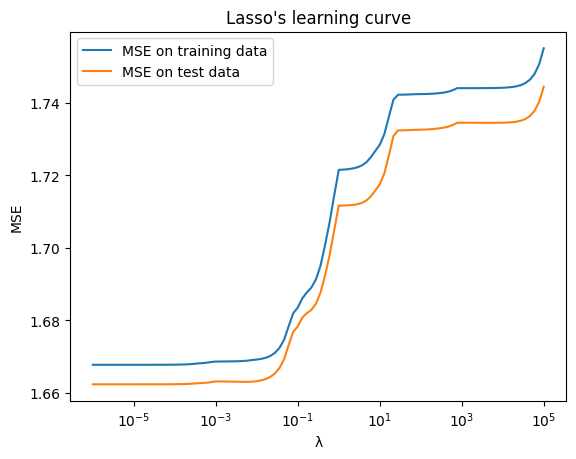

In [ ]:
# Plot the evolution of the MSE on training and testing data as a function of λ:
fig, ax = plt.subplots()

ax.plot(alphas, mse_trains, label='MSE on training data')
ax.plot(alphas, mse_tests, label='MSE on test data')

ax.set_xscale('log')
ax.set_xlabel('λ')
ax.set_ylabel('MSE')
ax.set_title('Lasso\'s learning curve')
ax.legend()

plt.show()


In [ ]:
# Select the value of λ having the best performance on test data and estimate a Lasso model with this λ:
Lasso_best_alpha = alphas[np.argmin(mse_tests)]
print(f'Best λ: {Lasso_best_alpha}')

lasso = Lasso(alpha=Lasso_best_alpha)
lasso.fit(x_train, y_train)

Best λ: 1e-06


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.743e+04, tolerance: 1.445e+01
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=1e-06)

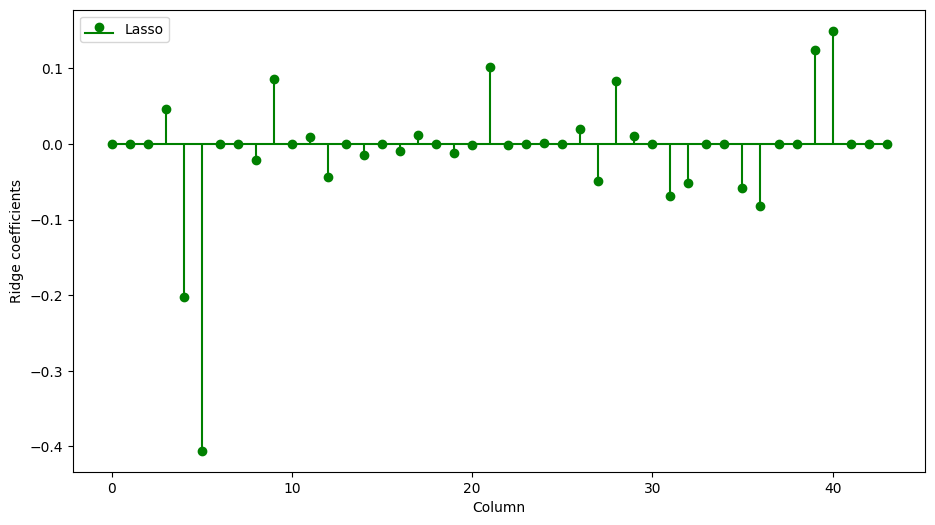

In [ ]:
# Interpret the classifiers w for the Lasso estimator by plotting their values and their absolute values:
Lasso_coef = lasso.coef_
Lasso_intercept = lasso.intercept_

fig, ax1 = plt.subplots(figsize=(11, 6))

ax1.stem(Lasso_coef, linefmt='g', basefmt='g', label='Lasso')

ax1.set_xlabel('Column')
ax1.set_ylabel('Ridge coefficients')

lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, loc='best')

plt.show()

In [ ]:
best_variables_id = list(np.argpartition(np.absolute(Lasso_coef), -14)[-14:])
best_variables_id.sort()
best_variables_id

[3, 4, 5, 9, 12, 21, 27, 28, 31, 32, 35, 36, 39, 40]

In [ ]:
best_variables = x_train.columns[best_variables_id]
best_variables_dic = {}
for id, variable in zip(best_variables_id, best_variables):
    best_variables_dic[variable] = Lasso_coef[id]
best_variables = sorted(best_variables_dic, key=best_variables_dic.get)
for variable in best_variables:
    print(f'{variable}: {best_variables_dic[variable]}')

piezo_continuity_code: -0.40563055188349517
piezo_station_latitude: -0.20247781082551927
prelev_latitude_1: -0.08214659301506025
prelev_longitude_0: -0.06915146482644366
prelev_longitude_1: -0.05850959375060452
prelev_latitude_0: -0.0513776598096403
hydro_longitude: -0.04919668306715737
meteo_temperature_min: -0.04427676868899496
piezo_station_longitude: 0.045545198478750444
hydro_latitude: 0.0837498714380153
meteo_longitude: 0.0851639551828993
meteo_evapotranspiration_grid: 0.10131278382486451
prelev_longitude_2: 0.12363746280474144
prelev_latitude_2: 0.1495588221996876


In [ ]:
x_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 80865 entries, 86493 to 15795
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   row_index                          80865 non-null  int64  
 1   piezo_station_investigation_depth  80865 non-null  float64
 2   piezo_station_altitude             80865 non-null  float64
 3   piezo_station_longitude            80865 non-null  float64
 4   piezo_station_latitude             80865 non-null  float64
 5   piezo_continuity_code              80865 non-null  float64
 6   piezo_producer_code                80865 non-null  float64
 7   meteo_id                           80865 non-null  int64  
 8   meteo_latitude                     80865 non-null  float64
 9   meteo_longitude                    80865 non-null  float64
 10  meteo_altitude                     80865 non-null  int64  
 11  meteo_rain_height                  80865 non-null  floa